In [1]:
# !gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

In [1]:
import pandas as pd

sunspots_df = pd.read_csv("sunspots.csv", usecols=["Date", "Monthly Mean Total Sunspot Number"])
sunspots_df["Date"] = pd.to_datetime(sunspots_df["Date"])
sunspots_df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [2]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = (12, 10)
import seaborn as sns

sns.set_style("white")
sns.set()

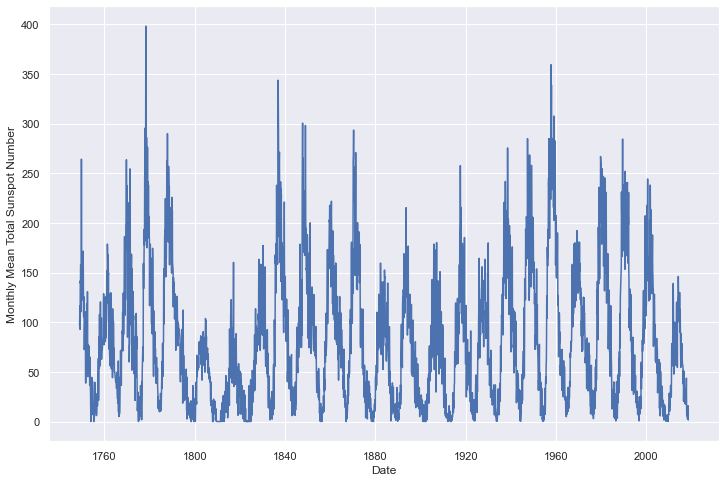

In [3]:
plt.figure(figsize=(12, 8))
sns.lineplot(x="Date", y="Monthly Mean Total Sunspot Number", data=sunspots_df)
plt.show()

In [4]:
import tensorflow as tf
import numpy as np


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

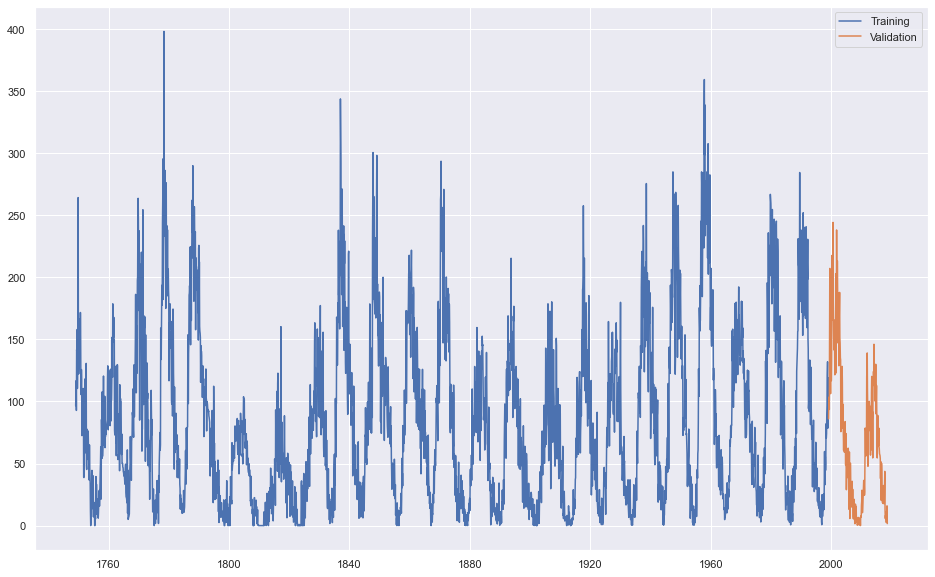

In [25]:
split_time = 3000
time_train = sunspots_df["Date"][:split_time]
x_train = sunspots_df["Monthly Mean Total Sunspot Number"][:split_time]
time_valid = sunspots_df["Date"][split_time:]
x_valid = sunspots_df["Monthly Mean Total Sunspot Number"][split_time:]

plt.figure(figsize=(16, 10))
plt.plot(time_train, x_train, label="Training")
plt.plot(time_valid, x_valid, label="Validation")
plt.legend()
plt.show()

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 60
batch_size = 150
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
        filters=60, kernel_size=3,
        strides=1, padding="causal",
        activation="relu",
        input_shape=[None, 1]
    ),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(60, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)
history_lr = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
20/20 [==============================] - 7s 202ms/step - loss: 121.5890 - mae: 122.0874 - lr: 1.0000e-08
Epoch 2/100
20/20 [==============================] - 5s 225ms/step - loss: 116.7660 - mae: 117.2646 - lr: 1.1220e-08
Epoch 3/100
20/20 [==============================] - 4s 205ms/step - loss: 111.0999 - mae: 111.5987 - lr: 1.2589e-08
Epoch 4/100
20/20 [==============================] - 5s 217ms/step - loss: 105.0108 - mae: 105.5096 - lr: 1.4125e-08
Epoch 5/100
20/20 [==============================] - 4s 212ms/step - loss: 98.1285 - mae: 98.6271 - lr: 1.5849e-08
Epoch 6/100
20/20 [==============================] - 5s 257ms/step - loss: 90.1183 - mae: 90.6167 - lr: 1.7783e-08
Epoch 7/100
20/20 [==============================] - 4s 207ms/step - loss: 82.4669 - mae: 82.9652 - lr: 1.9953e-08
Epoch 8/100
20/20 [==============================] - 5s 247ms/step - loss: 76.0484 - mae: 76.5465 - lr: 2.2387e-08
Epoch 9/100
20/20 [==============================] - 4s 209ms/step - los

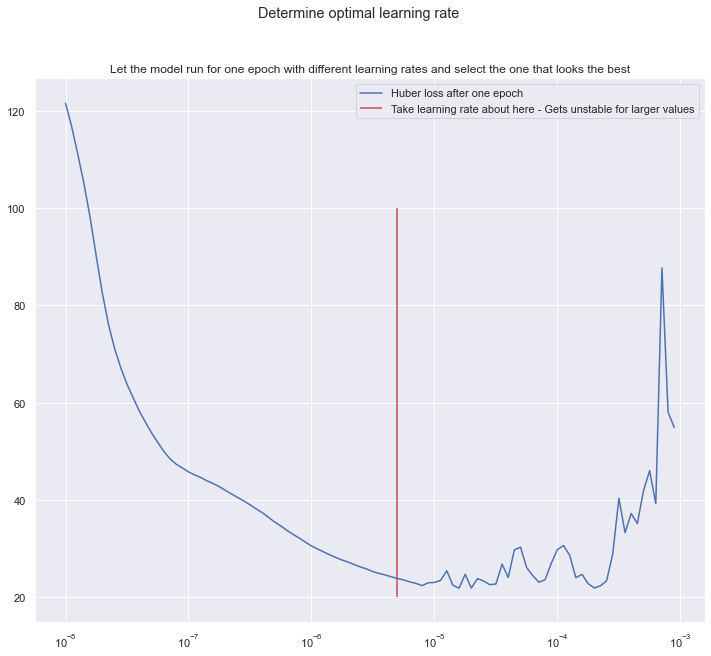

In [36]:
plt.semilogx(history_lr.history["lr"], history_lr.history["loss"], label="Huber loss after one epoch")
plt.suptitle("Determine optimal learning rate")
plt.title("Let the model run for one epoch with different learning rates and select the one that looks the best")
plt.vlines(x=5e-6, ymin=20, ymax=100, label="Take learning rate about here - Gets unstable for larger values",
           color="r")
plt.legend()
plt.show()

In [29]:
# main model

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
        filters=64, kernel_size=3,
        strides=1, padding="causal",
        activation="relu",
        input_shape=[None, 1]
    ),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          256       
                                                                 
 lstm (LSTM)                 (None, None, 64)          33024     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dropout (Dropout)           (None, None, 30)          0         
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           1

In [30]:
window_size = 30  # can experiment with this value
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

history = model.fit(dataset, epochs=400)

Epoch 1/400
93/93 [==============================] - 11s 55ms/step - loss: 57.9028 - mae: 58.4003
Epoch 2/400
93/93 [==============================] - 5s 54ms/step - loss: 48.0152 - mae: 48.5126
Epoch 3/400
93/93 [==============================] - 5s 58ms/step - loss: 42.1366 - mae: 42.6335
Epoch 4/400
93/93 [==============================] - 5s 54ms/step - loss: 37.9890 - mae: 38.4854
Epoch 5/400
93/93 [==============================] - 5s 55ms/step - loss: 35.2494 - mae: 35.7457
Epoch 6/400
93/93 [==============================] - 5s 54ms/step - loss: 32.9691 - mae: 33.4651
Epoch 7/400
93/93 [==============================] - 5s 56ms/step - loss: 31.1412 - mae: 31.6368
Epoch 8/400
93/93 [==============================] - 5s 52ms/step - loss: 29.8419 - mae: 30.3376
Epoch 9/400
93/93 [==============================] - 5s 55ms/step - loss: 28.4970 - mae: 28.9924
Epoch 10/400
93/93 [==============================] - 5s 56ms/step - loss: 27.3630 - mae: 27.8585
Epoch 11/400
93/93 [========

C:\Users\benja\AppData\Local\Temp/ipykernel_22076/2628655549.py:1: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



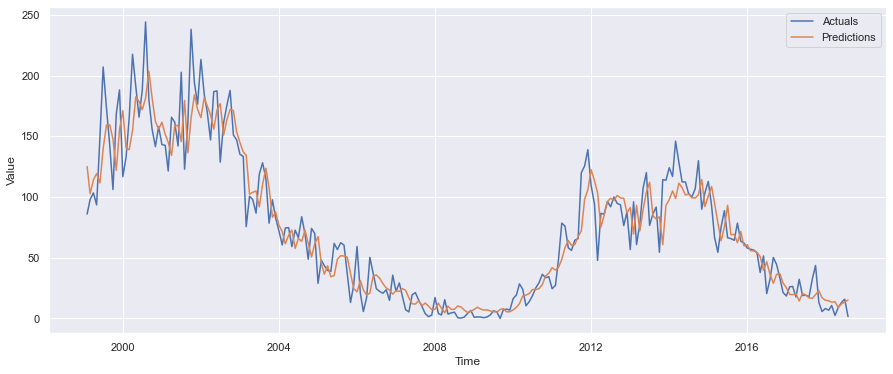

In [63]:
rnn_forecast = model_forecast(model, sunspots_df["Monthly Mean Total Sunspot Number"][..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]


def plot_series(time, series, format="-", start=0, end=None, label="default"):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


plt.figure(figsize=(15, 6))
plot_series(time_valid, x_valid, label="Actuals")
plot_series(time_valid, rnn_forecast, label="Predictions")
plt.legend()
plt.show()

In [34]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.440812

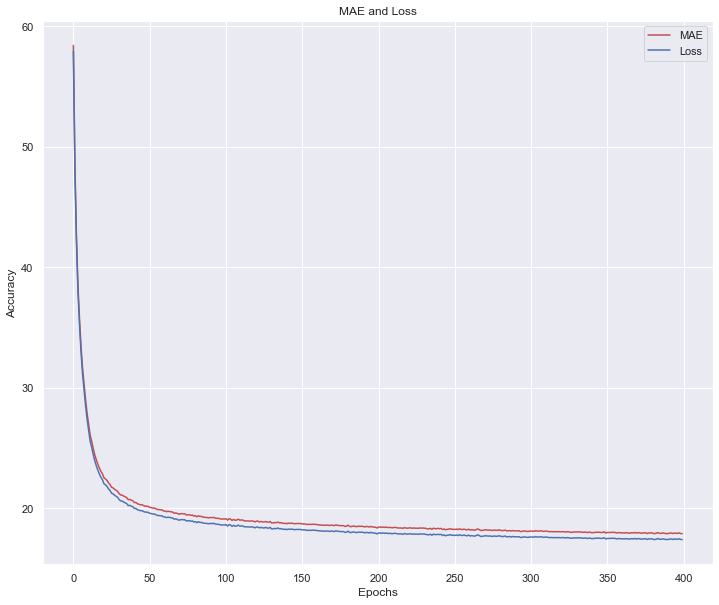

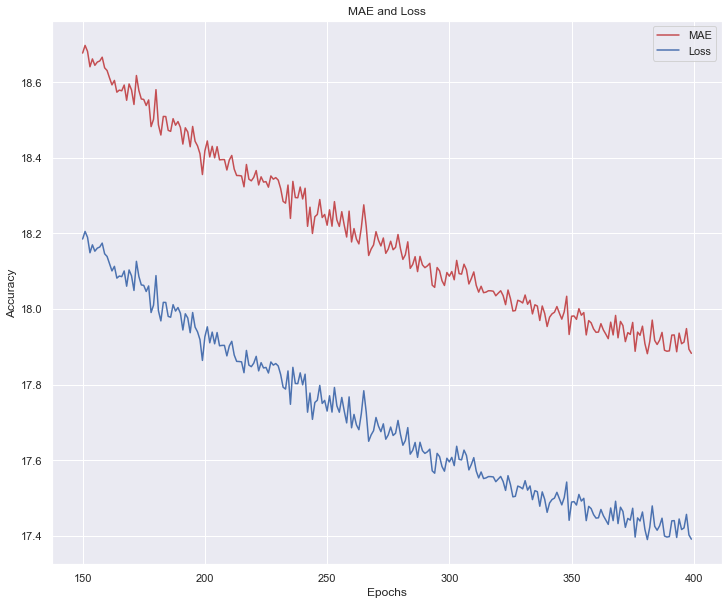

In [35]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))  # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[150:]
mae_zoom = mae[150:]
loss_zoom = loss[150:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])
# it is clear from the zoomed picture that the model continues to learn, albeit at a diminished rate
plt.show()

In [107]:
rnn_forecast_known_data = model_forecast(
    model,
    sunspots_df["Monthly Mean Total Sunspot Number"][..., np.newaxis],
    window_size
)
rnn_forecast_known_train = rnn_forecast_known_data[:split_time - window_size, -1, 0]
rnn_forecast_known_validation = rnn_forecast_known_data[split_time - window_size:-1, -1, 0]

C:\Users\benja\AppData\Local\Temp/ipykernel_22076/3924989358.py:3: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [108]:
import plotly.graph_objs as go

fig = go.Figure([
    go.Line(
        name="Training Actuals",
        x=time_train[30:],
        y=x_train[30:],
        line=dict(width=1),
        showlegend=True
    ),
    go.Line(
        name="Validation Predictions",
        x=time_train[30:],
        y=rnn_forecast_known_train,
        line=dict(width=1),
        showlegend=True
    ),
    go.Line(
        name="Validation Actuals",
        x=time_valid,
        y=x_valid,
        line=dict(width=1),
        showlegend=True
    ),
    go.Line(
        name="Validation Predictions",
        x=time_valid,
        y=rnn_forecast_known_validation,
        line=dict(width=1),
        showlegend=True
    ),
])

fig.update_layout(
    title="Sunspot Activity Predictions (Monthly Mean Number Of Sunspots)"
)

fig.show()

C:\Development\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


